# Sarcasm Detection Using BERT 

## Task 1: Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

import re
import tensorflow_hub as hub
import tensorflow_text

from official.nlp import optimization
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense
from tensorflow.keras.models import model_from_json
from matplotlib import rcParams

import math
from sklearn.metrics import classification_report, confusion_matrix
import os

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-04-07 09:41:14.763293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 09:41:16.091447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-07 09:41:16.091500: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-07 09:41:19.282050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

## Task 2: Load Dataset

In [3]:
train_df = pd.read_csv('/usercode/train.csv')
X_train = train_df[['text']].copy()
Y_train = train_df[['labels']].copy()

test_df = pd.read_csv('/usercode/test.csv')
X_test = test_df[['text']].copy()
Y_test = test_df[['labels']].copy()

valid_df = pd.read_csv('/usercode/validate.csv')
X_valid = valid_df[['text']].copy()
Y_valid = valid_df[['labels']].copy()

X_train.head()

,text
0,<user> thanks for showing up for our appointme...
1,haha . # lol
2,i love waiting <num> min for a cab - such shor...
3,22 super funny quotes # funnyquotes # funnysa...
4,goog morning # sorrynotsorry # morning


## Task 3: Pre-process Data

In [4]:
def preprocess(data):
  data = data.astype(str)
  data = data.apply(lambda x: x.lower())
  data = data.apply((lambda x: re.sub('[^a-zA-Z0-9\s]','',x)))

  for idx,row in enumerate(data):
      row = row.replace('rt',' ')

  return data

In [5]:
X_train["text"] = preprocess(X_train["text"])
X_valid["text"] = preprocess(X_valid["text"])
X_test["text"] = preprocess(X_test["text"])
X_train.head()

,text
0,user thanks for showing up for our appointment...
1,haha lol
2,i love waiting num min for a cab such shortag...
3,22 super funny quotes funnyquotes funnysayi...
4,goog morning sorrynotsorry morning


## Task 4: Choose the Model and its Preprocessor

In [6]:
keras.backend.clear_session()

encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## Task 5: Create the Classification model

In [7]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocessor_url, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [8]:
classifier_model = build_classifier_model()

2024-04-07 09:41:25.610290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-07 09:41:25.613226: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-07 09:41:25.613284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (educative): /proc/driver/nvidia/version does not exist
2024-04-07 09:41:25.613548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 6: Initialize the Parameters

In [9]:
epochs = 4
batch_size = 64
steps_per_epoch = math.floor(X_train.shape[0]/batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 3e-5

In [10]:
loss = tf.keras.losses.BinaryCrossentropy()

metrics = tf.metrics.BinaryAccuracy()

optimizer = optimization.create_optimizer(init_lr=init_lr,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type='adamw')

## Task 7: Load Trained Model

In [11]:
"""json_file = open('usercode/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

classifier_model = model_from_json(loaded_model_json, custom_objects={'KerasLayer':hub.KerasLayer})

classifier_model.load_weights("usercode/model.h5")
print("Loaded model from disk") """

'json_file = open(\'usercode/model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\n\nclassifier_model = model_from_json(loaded_model_json, custom_objects={\'KerasLayer\':hub.KerasLayer})\n\nclassifier_model.load_weights("usercode/model.h5")\nprint("Loaded model from disk") '

In [12]:
"""classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics) """

'classifier_model.compile(optimizer=optimizer,\n              loss=loss,\n              metrics=metrics) '

## Task 8: Train the Model

In [13]:
classifier_model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)

In [14]:
history = classifier_model.fit(X_train,
    pd.get_dummies(Y_train["labels"]),
    validation_data=(X_valid, pd.get_dummies(Y_valid["labels"])),
    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/4
310/310 [==============================] - 320s 1s/step - loss: 0.6909 - binary_accuracy: 0.5782 - val_loss: 0.5747 - val_binary_accuracy: 0.7017
Epoch 2/4
310/310 [==============================] - 305s 983ms/step - loss: 0.5698 - binary_accuracy: 0.7181 - val_loss: 0.5167 - val_binary_accuracy: 0.7444
Epoch 3/4
310/310 [==============================] - 304s 980ms/step - loss: 0.5209 - binary_accuracy: 0.7540 - val_loss: 0.4979 - val_binary_accuracy: 0.7552
Epoch 4/4
310/310 [==============================] - 303s 977ms/step - loss: 0.4977 - binary_accuracy: 0.7680 - val_loss: 0.4961 - val_binary_accuracy: 0.7539


## Task 9: Display the Training Curve

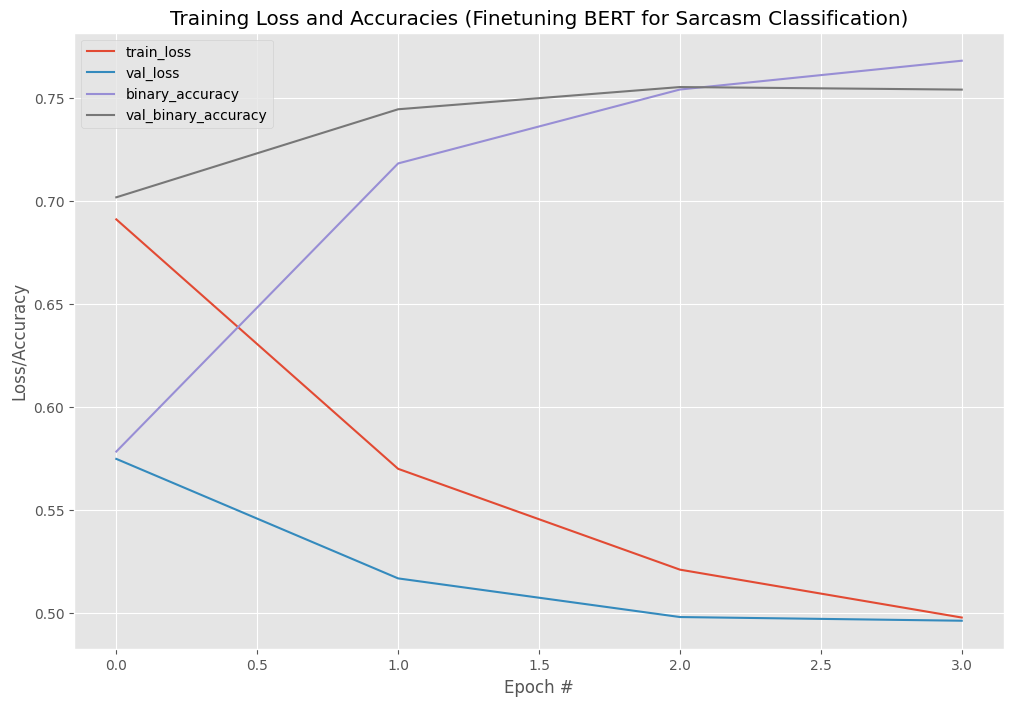

In [15]:
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history['binary_accuracy'], label="binary_accuracy")
plt.plot(N, history.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.title("Training Loss and Accuracies (Finetuning BERT for Sarcasm Classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Task 10: Evaluate the model

In [16]:
loss, accuracy = classifier_model.evaluate(X_test, pd.get_dummies(Y_test["labels"]))

print('Loss: ', loss)
print('Accuracy: ', accuracy)

76/76 [==============================] - 10s 136ms/step - loss: 0.4862 - binary_accuracy: 0.7754
Loss:  0.4861926734447479
Accuracy:  0.7754254937171936


In [17]:
actuals = Y_test["labels"]
Y_predicted = classifier_model.predict(X_test)
predictions= np.argmax(Y_predicted,axis=1)

76/76 [==============================] - 9s 115ms/step


## Task 11: Create a Confusion Matrix

Text(20.72222222222222, 0.5, 'True')

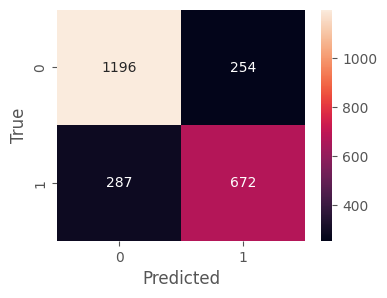

In [18]:
cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Task 12: Generate the Classification Report

In [19]:
target_names = ['Non-Sarcastic', "Sarcastic"]
print(classification_report(actuals, predictions, target_names=target_names))

               precision    recall  f1-score   support

Non-Sarcastic       0.81      0.82      0.82      1450
    Sarcastic       0.73      0.70      0.71       959

     accuracy                           0.78      2409
    macro avg       0.77      0.76      0.76      2409
 weighted avg       0.77      0.78      0.77      2409



# END